# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


    class Model:
        
        def predict(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of predicted classes.

        def certainty(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of certainty levels.

# Solutions
## 1. Model stem definition

<img src="images/resnet50_architecture.png" alt="Alternative text" />

Skip connection is used in each block, which consists of 3 conv layers. Skip connections are defined within BlockWithResiduals() class, in forward method.

<img src="images/skip_connection.png" alt="Alternative text" />

#### Model has been developed in Pytorch Lightning. Architecture is based on above stem.

In [1]:
from torchmetrics import Accuracy
import torch.nn as nn
import sys
from tqdm import tqdm

import torchvision
import torch
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import random

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# import mlflow
# import mlflow.pytorch
# from mlflow import MlflowClient

# import logging

# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)

# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_experiment("Training_resnet50")


class BlockWithResiduals(pl.LightningModule):
    def __init__(self, channels, start_expansion, end_expansion, stride):
        super(BlockWithResiduals, self).__init__()
        self.start_expansion = start_expansion
        self.end_expansion = end_expansion
        self.stride = stride
        self.residual_rescale = None

        self.conv_1 = nn.Conv2d(in_channels=channels*self.start_expansion, 
                                out_channels=channels, 
                                kernel_size=1, 
                                stride=1, 
                                padding=0)
        self.batch_norm_1 = nn.BatchNorm2d(channels)
        self.conv_2 = nn.Conv2d(in_channels=channels, 
                                out_channels=channels, 
                                kernel_size=3, 
                                stride=self.stride, 
                                padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(channels)
        self.conv_3 = nn.Conv2d(in_channels=channels, 
                                out_channels=self.end_expansion*channels, 
                                kernel_size=1, 
                                stride=1, 
                                padding=0)
        self.batch_norm_3 = nn.BatchNorm2d(self.end_expansion*channels)

        if self.start_expansion != self.end_expansion:
            self.residual_rescale = nn.Sequential(
                    nn.Conv2d(channels*self.start_expansion, 
                            channels*self.end_expansion, 
                            kernel_size=1, 
                            stride=self.stride),
                    nn.BatchNorm2d(channels*self.end_expansion)
                )

        self.relu = nn.ReLU()

    def forward(self, x):
        input_x = x.clone()
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.batch_norm_3(self.conv_3(x))

        # skip connection
        if self.residual_rescale is not None:
            input_x = self.residual_rescale(input_x)
        x = self.relu(x + input_x)

        return x

class MyResNet50(pl.LightningModule):
    def __init__(self, lr):
        super(MyResNet50, self).__init__()
        self.in_channels = 64
        self.expansion = 4
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

        self.input_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.blocks_layers_1 = self.make_initial_blocks_layer(sublayers_num=3, bl_channels=64, stride=1)
        self.blocks_layers_2 = self.make_blocks_layer(sublayers_num=4, bl_channels=128, stride=2)
        self.blocks_layers_3 = self.make_blocks_layer(sublayers_num=6, bl_channels=256, stride=2)
        self.blocks_layers_4 = self.make_blocks_layer(sublayers_num=3, bl_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*self.expansion, 10)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.input_conv(x)))
        x = self.max_pool(x)
        x = self.blocks_layers_1(x)
        x = self.blocks_layers_2(x)
        x = self.blocks_layers_3(x)
        x = self.blocks_layers_4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def make_initial_blocks_layer(self, sublayers_num, bl_channels, stride):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=1, end_expansion=self.expansion, stride=stride))
            else:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion, stride=stride))

        return nn.Sequential(*blocks_layers)

    def make_blocks_layer(self, sublayers_num, bl_channels, stride):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=2, end_expansion=self.expansion, stride=stride))
            else:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion, stride=1))          
                

        return nn.Sequential(*blocks_layers)

    def training_step(self, batch, batch_nb):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)

        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_nb):
        x_val, y_val = batch
        preds_val = self(x_val)
        loss_val = self.loss_fn(preds_val, y_val)

        accuracy = Accuracy().to(self.device)
        acc = accuracy(preds_val, y_val)
        self.log('accuracy', acc, on_epoch=True)
        self.log("validation_loss", loss_val, on_epoch=True)

        return loss_val
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=0.0001)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5),
            # "interval": "epoch",
            "monitor": "validation_loss",
            # "frequency": 5
        },
    }

    def predict(self, input_array: np.ndarray) -> np.ndarray:
        sm = nn.Softmax(dim=1)
        preds = self(torch.Tensor(input_array))
        preds = sm(preds)
        
        return preds.cpu().detach().numpy()

    def certainty(self, input_array: np.ndarray) -> np.ndarray:
        predictions = self.predict(input_array)
        certanities = torch.amax(torch.Tensor(predictions), dim=1)
        
        return certanities.cpu().detach().numpy()


#### Loading CIFAR10 dataset from torchvision datasets and adjusting for training/predictions

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100*batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# 2. Training model

#### Model was trained and monitored using MLFlow Tracking framework. Best 5 models (based on Accuracy) were saved for future use.

In [ ]:
model = MyResNet50(lr=0.1)
checkpoint_callback = ModelCheckpoint(
    monitor='accuracy',
    mode = 'max',
    save_top_k=5,
    dirpath='saved_models/',
    filename='resnet50_model-{epoch:02d}-{train_loss:.2f}-{validation_loss:.2f}-{accuracy:.2f}'
)

trainer = pl.Trainer(max_epochs=200, accelerator='gpu', devices=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)

#### Trained model achieved 85% accuracy on test CIFAR10 dataset after around 50 epochs. Model weights have ben saved as "resnet50_model-epoch=87-train_loss=0.28-validation_loss=0.48-accuracy=0.85.ckpt"

Accuracy:

<img src="images/model_acc.png" alt="Alternative text" />

Train and validation loss:

<img src="images/model_loss.png" alt="Alternative text" />

## 3. Predictions and certainity

#### Loading pretrained model:

In [3]:
model = MyResNet50(lr=0.1)
checkpoint = torch.load('saved_models/resnet50_model-epoch=87-train_loss=0.28-validation_loss=0.48-accuracy=0.85.ckpt')
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

##### The simpliest way to mesure model certainity for a prediction is to look at the biggest value given to a class (which is the predicted class). The closer the value is to 1, the more model is certain about its prediction.

In [4]:
dataiter = iter(testloader)
X, y = dataiter.next()

In [5]:
predictions = model.predict(X.numpy())
certanities = model.certainty(X.numpy())

In [6]:
correct_preds = []
correct_preds_cert = []
wrong_preds = []
wrong_preds_cert = []

for i in tqdm(range(predictions.shape[0])):
    if np.argmax(predictions[i]) == y[i].item():
        correct_preds.append(predictions[i])
        correct_preds_cert.append(certanities[i])
    else:
        wrong_preds.append(predictions[i])
        wrong_preds_cert.append(certanities[i])

100%|██████████| 10000/10000 [00:00<00:00, 137379.88it/s]


#### Histograms of certainity metric for correct and wrong predictions

Looking at distributions of certanities it is visible that once the model is "certain" (max class value close to 1) usually it is correct. When the model gets the class wrong, values of biggest class are usually significantly smaller than 1. Although, sometimes model is certain about the class, but still it classifies it wrongly.

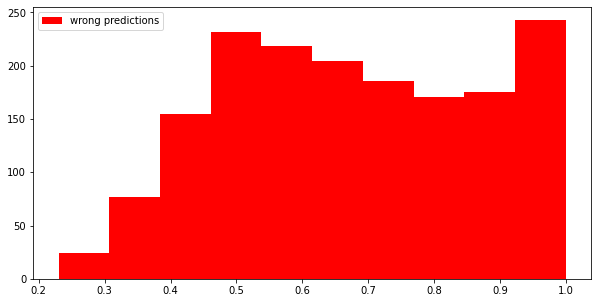

In [9]:
plt.figure(figsize=(10,5))
plt.hist(wrong_preds_cert, color='red', label='wrong predictions')
plt.legend()

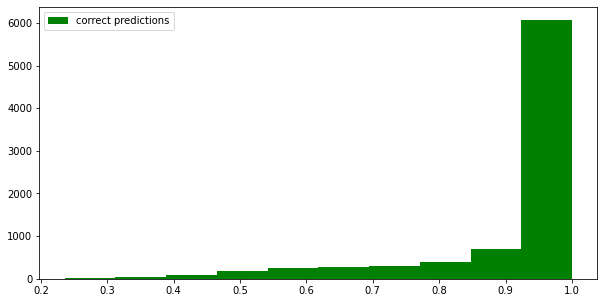

In [10]:
plt.figure(figsize=(10,5))
plt.hist(correct_preds_cert, color='green', label='correct predictions')
plt.legend()

#### Example predictions with certaininty level

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_example_pred():
    i = random.randint(0, len(predictions))
    print(f'Predicted: {classes[np.argmax(predictions[i])]}')
    print(f'Truth: {classes[y[i].numpy()]}')
    print(f'Certainity: {round(certanities[i], 2)}')

    imshow(torchvision.utils.make_grid(X[i]))

Predicted: plane
Truth: plane
Certainity: 0.9900000095367432


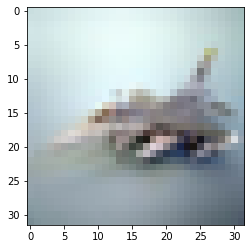

In [54]:
show_example_pred()